### Focus on stock price rise only

In [1]:
import numpy as np
import warnings
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
from yahoo_fin import stock_info as si
import pandas as pd
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
yf.pdr_override()

In [2]:
num_of_years = 1
start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
end = dt.date.today()

In [ ]:
df = pd.read_csv('data/mktcap.csv', index_col=0)
df = df[df['mktcap']>0]

In [ ]:
def stock_begin_timegap(stock):
    num_of_years = 1
    start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
    stock_start = yf.download(stock, start=start).index[0]
    return (stock_start - pd.to_datetime(start)).days

In [ ]:
df['gap'] = df['stock'].apply(stock_begin_timegap)

In [ ]:
df

In [ ]:
stock_df = df[df['gap'] <= 5]

### Find correlation

In [ ]:
tickers = stock_df['stock'].to_list()
dataset = pdr.get_data_yahoo(tickers, start, end)['Adj Close']

### Load datasets

In [3]:
dataset = pd.read_csv('data/all_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)

In [4]:
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
prevday_returns[prevday_returns < 0] = 0
today_returns = np.log(dataset/dataset.shift(1))
today_returns[today_returns < 0] = 0

In [5]:
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()

In [6]:
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col

In [7]:
comb_df = pd.concat([prevday_returns, today_returns], axis=1)

In [8]:
%%time
print('\nCorrelation Matrix')
corr_matrix = comb_df.corr()
# print(corr_matrix)


Correlation Matrix
CPU times: user 8.7 s, sys: 91.8 ms, total: 8.79 s
Wall time: 8.78 s


In [9]:
corr_matrix_corrected = corr_matrix.loc[new_col, stocks_today]

### What to drop

In [10]:
sorted_corr = corr_matrix_corrected.abs().unstack().sort_values(ascending=False)
sorted_corr.shape

(4713241,)

In [11]:
sorted_corr.head(10)

6898.HK  1216.HK.prev    0.873743
0068.HK  0993.HK.prev    0.859883
0422.HK  0127.HK.prev    0.858560
0277.HK  8001.HK.prev    0.854863
1216.HK  1371.HK.prev    0.845586
0496.HK  0608.HK.prev    0.843946
1371.HK  1143.HK.prev    0.832390
1121.HK  1195.HK.prev    0.830744
6858.HK  1559.HK.prev    0.791566
0458.HK  6858.HK.prev    0.778425
dtype: float64

### Charting

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import yfinance as yf 
import talib as TA
from datetime import datetime

from dateutil.relativedelta import relativedelta

In [13]:
start

datetime.date(2019, 11, 17)

In [22]:
stock1 = '6898.HK'
stock2 = '8612.HK'
df1 = yf.download(stock1, start=start)
df1['Date'] = df1.index
df1['Date'] = df1['Date'].apply(mdates.date2num)
df2 = yf.download(stock2, start=start)
df2['Date'] = df2.index
df2['Date'] = df2['Date'].apply(mdates.date2num)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


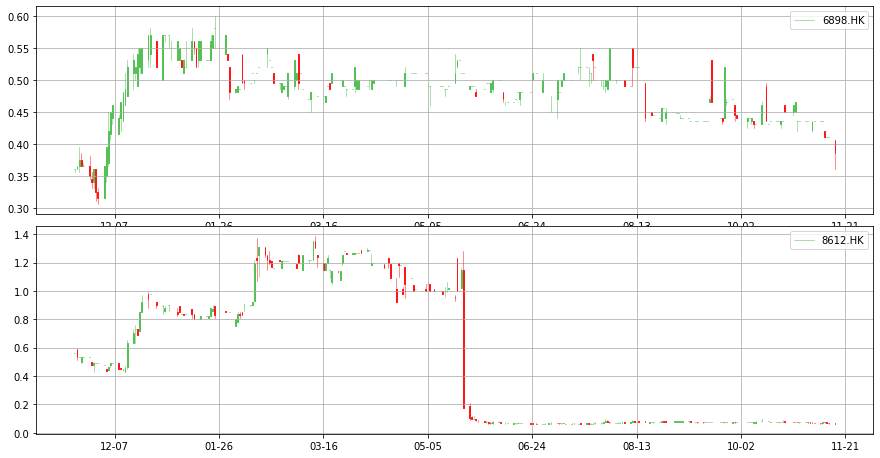

In [23]:
ohlc_seq = ['Date', 'Open', 'High', 'Low', 'Close']
fig = plt.figure(figsize = (15,20))
# fig.suptitle('{}.HK {}'.format(label, start_date.year), fontsize=18)
current_row = 0
ax_height = 3
ax0 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4)
ax0.grid(True)
candlestick_ohlc(ax0, df1[ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax0.legend([stock1])
#
current_row = current_row + ax_height
ax_height = 3
ax1 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4, sharex=ax0)
ax1.grid(True)
candlestick_ohlc(ax1, df2[ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.legend([stock2])

### Zoom into a period

In [24]:
chart_start = '12/01/2019'
chart_end = '12/31/2019'

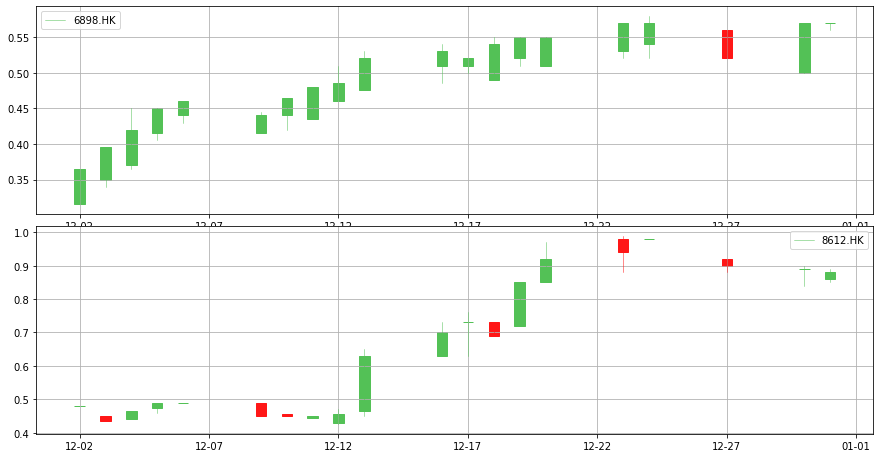

In [25]:
ohlc_seq = ['Date', 'Open', 'High', 'Low', 'Close']
fig = plt.figure(figsize = (15,20))
# fig.suptitle('{}.HK {}'.format(label, start_date.year), fontsize=18)
current_row = 0
ax_height = 3
ax0 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4)
ax0.grid(True)
candlestick_ohlc(ax0, df1.loc[chart_start:chart_end,ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax0.legend([stock1])
#
current_row = current_row + ax_height
ax_height = 3
ax1 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4, sharex=ax0)
ax1.grid(True)
candlestick_ohlc(ax1, df2.loc[chart_start:chart_end,ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.legend([stock2])

### More Analysis

In [26]:
prev_stock = '{}.prev'.format(stock1)
now_stock = stock2
compare_df = pd.concat([prevday_returns[prev_stock], today_returns[now_stock]], axis=1)

In [27]:
compare_df[compare_df[prev_stock]>0].count()

6898.HK.prev    72
8612.HK         70
dtype: int64

In [28]:
compare_df[(compare_df[prev_stock]>0) & (compare_df[now_stock]==0)].count()

6898.HK.prev    46
8612.HK         46
dtype: int64

In [29]:
compare_df[(compare_df[prev_stock]>0) & (compare_df[now_stock]>0)].count()

6898.HK.prev    24
8612.HK         24
dtype: int64